# Import libries

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load the data

In [229]:
# EN
# Upload the data file and ensure it is formatted correctly

# PT-BR
# Carregar o arquivo de dados e garantir que ele está formatado corretamente

df = pd.read_csv('./all_bovespa.csv')

In [231]:
# Verify that the file contains valid data
# Verifica se o arquivo contém dados válidos
def validate_data(df):
    required_columns = ['preaching_date', 'acronym_stock', 'price_closing']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Coluna obrigatória ausente: {col}")
    if df.isnull().sum().any():
        raise ValueError("The data file contains null values ​​that may affect the MACD calculation.")
    print("Data validated successfully.")

validate_data(df)

df.head()

Data validated successfully.


,preaching_date,acronym_stock,name_stock,opening_price,maximum_price,minimum_price,price_closing,qt_business,business_volume
0,2002-01-02,ACES3,ACESITA,0.60,0.63,0.60,0.61,1.165000e+08,7277700.0
1,2002-01-02,ACES4,ACESITA,0.71,0.73,0.70,0.72,2.624600e+09,188382700.0
2,2002-01-03,ACES3,ACESITA,0.63,0.63,0.61,0.61,4.769000e+08,29896700.0
3,2002-01-02,ALBA3,ALBARUS,0.85,0.85,0.85,0.85,1.000000e+03,85000.0
4,2002-01-03,ACES4,ACESITA,0.72,0.74,0.72,0.72,2.107300e+09,153041800.0


In [233]:
df_brasil = df.loc[df['acronym_stock'] == 'BBAS3']

# Checking data types

In [236]:
df_brasil.dtypes

preaching_date      object
acronym_stock       object
name_stock          object
opening_price      float64
maximum_price      float64
minimum_price      float64
price_closing      float64
qt_business        float64
business_volume    float64
dtype: object

# Changing preaching date to datetime

In [239]:
df_brasil['preaching_date'] = pd.to_datetime(df_brasil['preaching_date'], format='%Y-%m-%d')

C:\Users\Joao\AppData\Local\Temp\ipykernel_3468\2702968538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brasil['preaching_date'] = pd.to_datetime(df_brasil['preaching_date'], format='%Y-%m-%d')


In [241]:
df_brasil.dtypes

preaching_date     datetime64[ns]
acronym_stock              object
name_stock                 object
opening_price             float64
maximum_price             float64
minimum_price             float64
price_closing             float64
qt_business               float64
business_volume           float64
dtype: object

# Filtering a period

In [244]:
df_brasil_2022 = df_brasil[df_brasil['preaching_date'] >= '2021-12-31']

In [246]:
df_brasil_2022

,preaching_date,acronym_stock,name_stock,opening_price,maximum_price,minimum_price,price_closing,qt_business,business_volume
1655413,2022-02-03,BBAS3,BRASIL,32.08,32.58,32.02,32.29,11751300.0,3.794011e+10
1655806,2022-01-03,BBAS3,BRASIL,29.13,29.76,28.80,28.82,16169300.0,4.706998e+10
1657176,2022-02-21,BBAS3,BRASIL,36.14,36.23,34.97,35.28,12054400.0,4.280120e+10
1657274,2022-01-19,BBAS3,BRASIL,30.96,31.29,30.71,31.01,13372800.0,4.151773e+10
1658577,2022-02-04,BBAS3,BRASIL,32.20,32.41,32.01,32.23,7384200.0,2.380052e+10
...,...,...,...,...,...,...,...,...,...
2009960,2024-12-20,BBAS3,BRASIL,23.92,24.14,23.87,24.08,49163700.0,1.180358e+11
2010480,2024-12-23,BBAS3,BRASIL,24.07,24.13,23.88,23.92,12707900.0,3.046156e+10
2010762,2024-12-26,BBAS3,BRASIL,23.95,24.40,23.93,24.20,15208900.0,3.684838e+10
2010995,2024-12-27,BBAS3,BRASIL,24.34,24.37,24.11,24.11,10459500.0,2.532602e+10


# Adjust the index to preaching of date

In [249]:
df_brasil_2022 = df_brasil_2022.set_index(pd.DatetimeIndex(df_brasil_2022['preaching_date'].values))

In [251]:
df_brasil_2022 = df_brasil_2022.drop('preaching_date', axis='columns')

In [253]:
# Sort data by index (date)
# Ordenar os dados por índice (data)
df_brasil_2022 = df_brasil_2022.sort_index()

# Veryfing inconsisteces data

In [256]:
# Remove duplicates in the index
# Remover duplicatas no índice
df_brasil_2022 = df_brasil_2022[~df_brasil_2022.index.duplicated(keep='first')]


# Check and handle missing values ​​in filtered data
# Verificar e tratar valores ausentes nos dados filtrados
def check_filtered_data(df):
    if df.empty:
        raise ValueError("No data found for the applied filter.")
    if df.isnull().sum().any():
        print("Null values ​​found, applying interpolation.")
        df.interpolate(inplace=True)
    print("Filtered data is complete and consistent.")

check_filtered_data(df_brasil_2022)

Filtered data is complete and consistent.


# Calculating average movement using (MACD)

In [259]:
fastMME = df_brasil_2022.price_closing.ewm(span=12).mean()
lowerMME = df_brasil_2022.price_closing.ewm(span=26).mean()
MACD = fastMME - lowerMME
sinal = MACD.ewm(span=9).mean()

# Visualizing graph

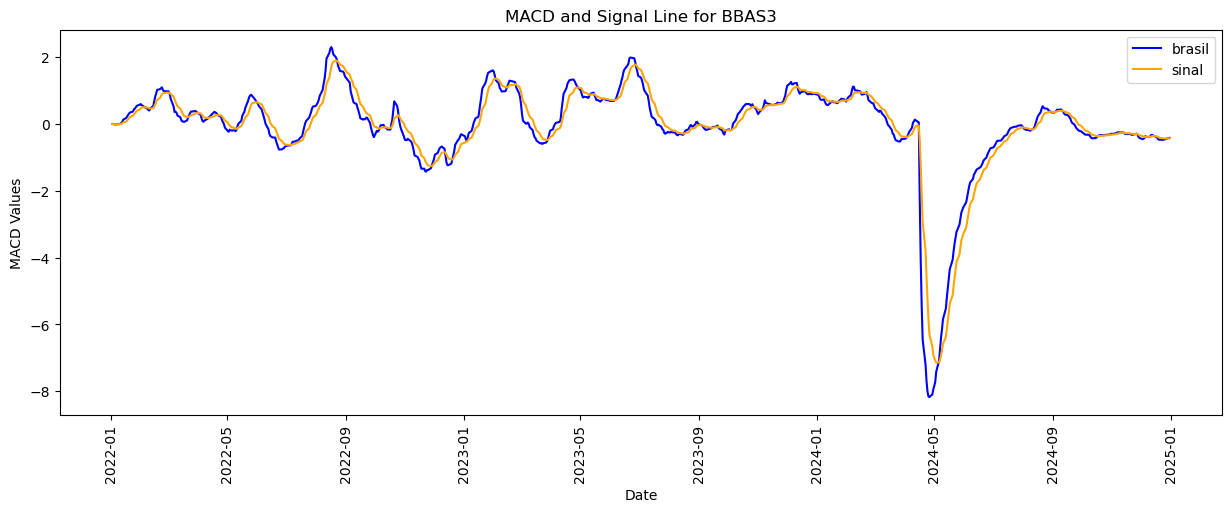

In [262]:
plt.figure(figsize=(15,5))
plt.plot(df_brasil_2022.index, MACD, label='brasil', color='blue')
plt.plot(df_brasil_2022.index, sinal, label='sinal', color='orange')
plt.xlabel('Date')
plt.ylabel('MACD Values')
plt.title('MACD and Signal Line for BBAS3')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

Data validated successfully.
Filtered data is complete and consistent.


C:\Users\Joao\AppData\Local\Temp\ipykernel_3468\97771397.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brasil['preaching_date'] = pd.to_datetime(df_brasil['preaching_date'], format='%Y-%m-%d')


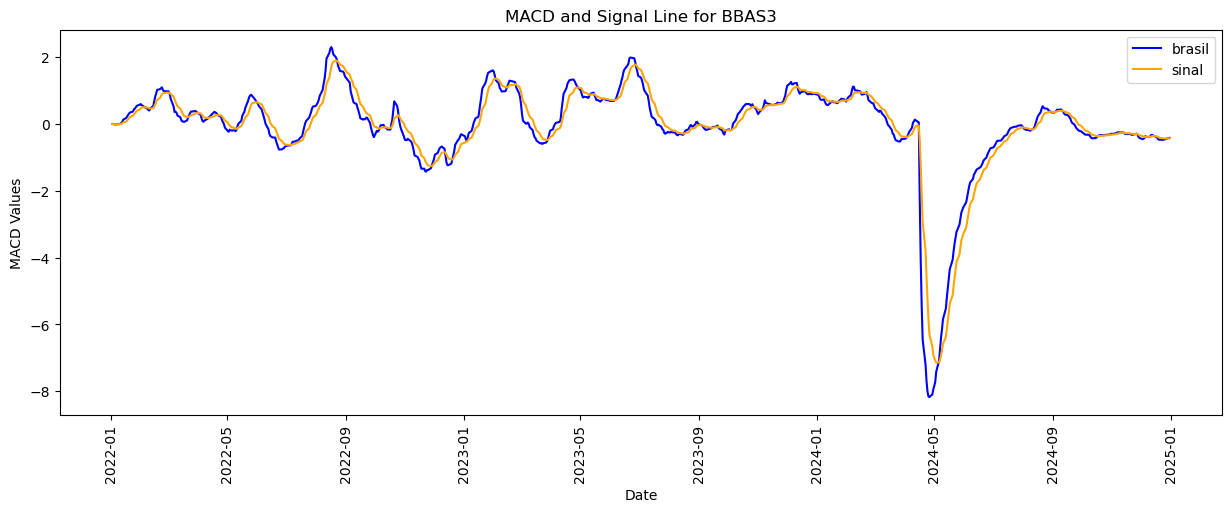

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
















